# Capstone 3 : Electronic Sales Data

> Business Case: Marketing requests some analysis on the previous year's sales data, to help discover customer segments for targeted advertising and promotional campaigns.

This notebook is split into sections, with each focusing on specific (or related) aspects of data extraction, transformation and analysis. At a high level, the progression is:
- Extracting data from CSV into a DataFrame
- Inspect & Transform data (cleaning, outliers etc...)
- Feature Selection
- Unsupervised Models: `UMAP` `t-SNE`
- Clustering: `KMeans` `DBSCAN`
- Summary

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.ticker as mticker
!pip install umap-learn
import umap
import time
import warnings

# Importing & Cleaning Data


In [2]:
df = pd.read_csv("https://gist.githubusercontent.com/scscodes/d8350db9e09cc6670bd85bcc799c1f72/raw/ba37ad2589bc50d6e90fca95981c479a76ff3874/electronic-sales.csv").dropna()

In [3]:
df.head()

,Customer ID,Age,Gender,Loyalty Member,Product Type,SKU,Rating,Order Status,Payment Method,Total Price,Unit Price,Quantity,Purchase Date,Shipping Type,Add-ons Purchased,Add-on Total
0,1000,53,Male,No,Smartphone,SKU1004,2,Cancelled,Credit Card,5538.33,791.19,7,3/20/2024,Standard,"Accessory,Accessory,Accessory",40.21
1,1000,53,Male,No,Tablet,SKU1002,3,Completed,Paypal,741.09,247.03,3,4/20/2024,Overnight,Impulse Item,26.09
3,1002,41,Male,Yes,Smartphone,SKU1004,2,Completed,Cash,3164.76,791.19,4,8/9/2024,Overnight,"Impulse Item,Impulse Item",60.16
4,1003,75,Male,Yes,Smartphone,SKU1001,5,Completed,Cash,41.50,20.75,2,5/21/2024,Express,Accessory,35.56
5,1004,41,Female,No,Smartphone,SKU1001,5,Completed,Credit Card,83.00,20.75,4,5/26/2024,Standard,"Impulse Item,Accessory",65.78


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15132 entries, 0 to 19998
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer ID        15132 non-null  int64  
 1   Age                15132 non-null  int64  
 2   Gender             15132 non-null  object 
 3   Loyalty Member     15132 non-null  object 
 4   Product Type       15132 non-null  object 
 5   SKU                15132 non-null  object 
 6   Rating             15132 non-null  int64  
 7   Order Status       15132 non-null  object 
 8   Payment Method     15132 non-null  object 
 9   Total Price        15132 non-null  float64
 10  Unit Price         15132 non-null  float64
 11  Quantity           15132 non-null  int64  
 12  Purchase Date      15132 non-null  object 
 13  Shipping Type      15132 non-null  object 
 14  Add-ons Purchased  15132 non-null  object 
 15  Add-on Total       15132 non-null  float64
dtypes: float64(3), int64(4), ob

In [7]:
# Check for missing values
df.isnull().sum()

,0
Customer ID,0
Age,0
Gender,0
Loyalty Member,0
Product Type,0
SKU,0
Rating,0
Order Status,0
Payment Method,0
Total Price,0


In [8]:
# Feature summary
df.describe()

,Customer ID,Age,Rating,Total Price,Unit Price,Quantity,Add-on Total
count,15132.000000,15132.000000,15132.000000,15132.000000,15132.000000,15132.000000,15132.000000
mean,10503.843841,48.992400,3.088686,3184.261850,580.367742,5.473236,82.269162
std,5614.621186,18.020315,1.226645,2547.867058,311.934802,2.879513,52.988196
min,1000.000000,18.000000,1.000000,20.750000,20.750000,1.000000,5.010000
25%,5534.500000,34.000000,2.000000,1139.680000,361.180000,3.000000,42.360000
50%,11036.500000,49.000000,3.000000,2534.490000,674.320000,5.000000,71.990000
75%,15514.500000,65.000000,4.000000,4639.600000,791.190000,8.000000,108.965000
max,19997.000000,80.000000,5.000000,11396.800000,1139.680000,10.000000,292.770000


In [9]:
# Closer look at certain features that may be more relevant

# df.head() showed Completed/Cancelled values for Order Status...
# If Marketing was targeting conversion failures (people who did not complete an order), it may be appropriate to drop 'Completed' records
# Since Marketing is targeting ALL customer segments, we will retain both
df['Order Status'].value_counts(), df['Loyalty Member'].value_counts()

(Order Status
 Completed    10145
 Cancelled     4987
 Name: count, dtype: int64,
 Loyalty Member
 No     11842
 Yes     3290
 Name: count, dtype: int64)

In [10]:
# Removing upper and lower quartiles of sales by Total Price.
# This should remove any risk of commercial or bulk sales that may otherwise skew the data.
Q1 = df['Total Price'].quantile(0.25)
Q3 = df['Total Price'].quantile(0.75)
IQR = Q3 - Q1

# Defining outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering outliers and creating a new DF
dfc = df[(df['Total Price'] >= lower_bound) & (df['Total Price'] <= upper_bound)]

dfc.describe()

,Customer ID,Age,Rating,Total Price,Unit Price,Quantity,Add-on Total
count,14849.000000,14849.000000,14849.000000,14849.000000,14849.000000,14849.000000,14849.000000
mean,10412.579366,48.988215,3.090915,3037.720675,569.708077,5.395717,81.745781
std,5616.668920,18.027452,1.223184,2336.856708,305.093075,2.850188,52.689017
min,1000.000000,18.000000,1.000000,20.750000,20.750000,1.000000,5.010000
25%,5448.000000,34.000000,2.000000,1083.540000,361.180000,3.000000,42.120000
50%,9880.000000,49.000000,3.000000,2528.260000,463.960000,5.000000,71.500000
75%,15433.000000,65.000000,4.000000,4595.000000,791.190000,8.000000,107.990000
max,19997.000000,80.000000,5.000000,9117.440000,1139.680000,10.000000,292.770000


In [11]:
# To compare against our original...
df.describe()

,Customer ID,Age,Rating,Total Price,Unit Price,Quantity,Add-on Total
count,15132.000000,15132.000000,15132.000000,15132.000000,15132.000000,15132.000000,15132.000000
mean,10503.843841,48.992400,3.088686,3184.261850,580.367742,5.473236,82.269162
std,5614.621186,18.020315,1.226645,2547.867058,311.934802,2.879513,52.988196
min,1000.000000,18.000000,1.000000,20.750000,20.750000,1.000000,5.010000
25%,5534.500000,34.000000,2.000000,1139.680000,361.180000,3.000000,42.360000
50%,11036.500000,49.000000,3.000000,2534.490000,674.320000,5.000000,71.990000
75%,15514.500000,65.000000,4.000000,4639.600000,791.190000,8.000000,108.965000
max,19997.000000,80.000000,5.000000,11396.800000,1139.680000,10.000000,292.770000


# Summary: Cleaning & Visual Inspection
- No features with missing values.
- All records appear complete and valid.
- Removed outer quartiles to prevent any bulk/commercial sales totals that may skew Total Price values.
- Several features and relations of interest, which may warrant additional research or could help build context for presentation!

### ... future analysis opportunties
- Product Types + Product Reviews + Returns
- Loyalty Status + Conversion
- Product trends by Season

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


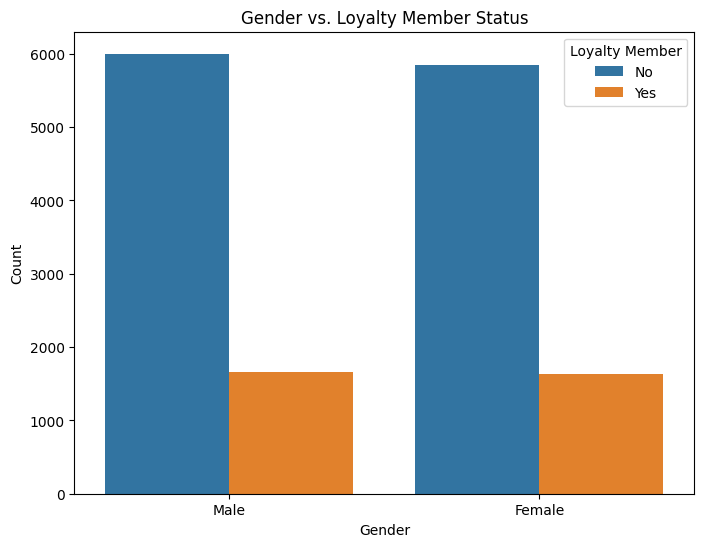

In [12]:
# Plot Gender to Loyalty Member status

plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', hue='Loyalty Member', data=df)
plt.title('Gender vs. Loyalty Member Status')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

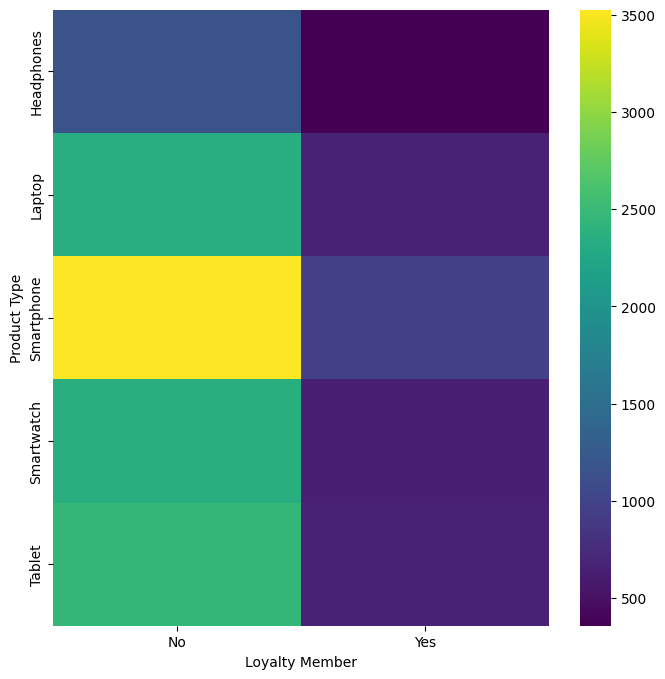

In [13]:
# Plot Products and Loyalty Membership; identify products that may have stronger relationship with Loyalty status

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Product Type'].value_counts()
    for x_label, grp in df.groupby('Loyalty Member')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Loyalty Member')
_ = plt.ylabel('Product Type')

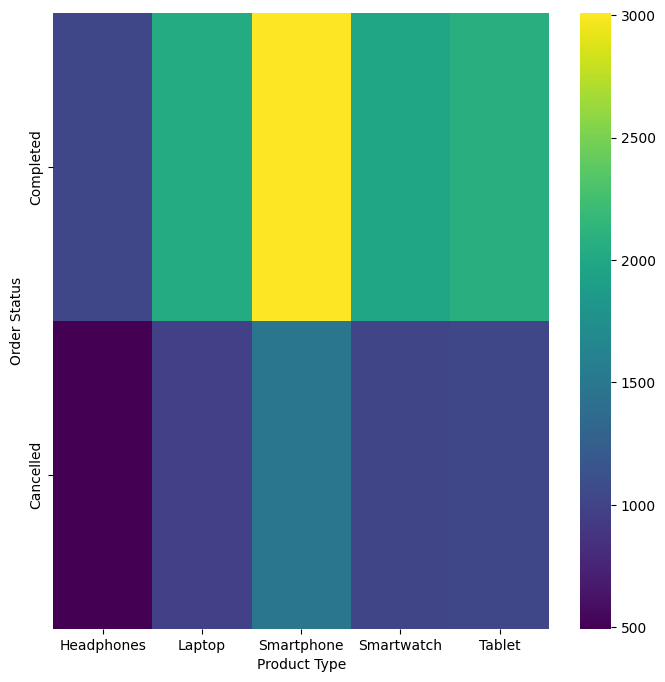

In [14]:
# Plot Order Status by Type; identify positive or negative correlations in conversion

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Order Status'].value_counts()
    for x_label, grp in df.groupby('Product Type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Product Type')
_ = plt.ylabel('Order Status')

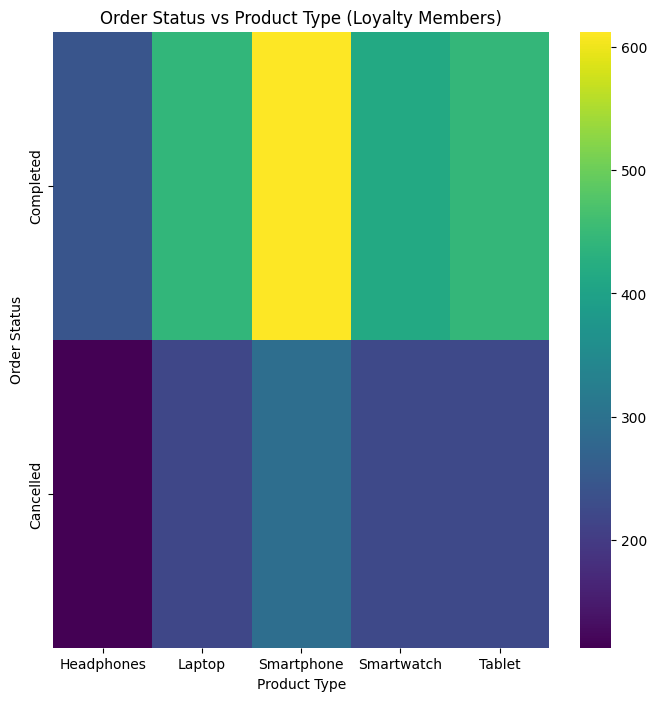

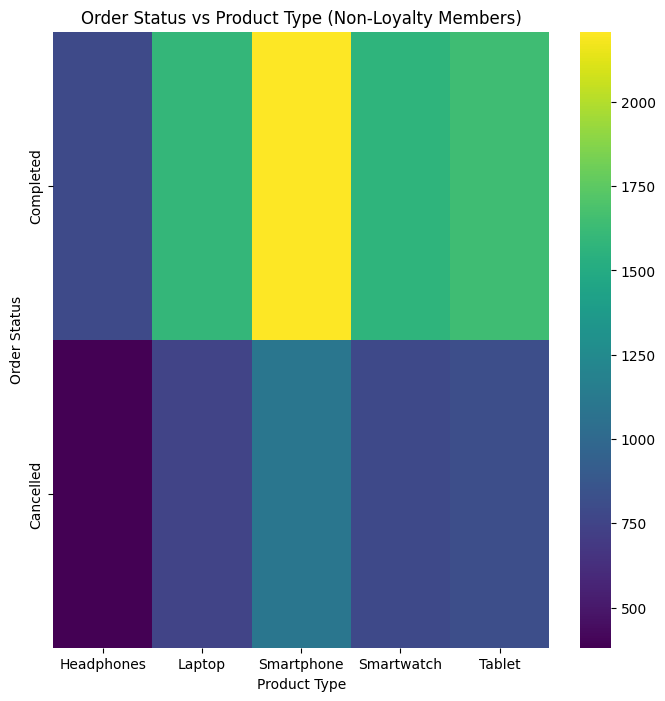

In [26]:
# Compare heatmaps between Loyalty and Non-Loyalty members, to see if there are any discerable differences in cancellations

# Plot Order Status by Type for Loyalty Members
plt.subplots(figsize=(8, 8))
df_loyalty = dfc[dfc['Loyalty Member'] == 'Yes']
df_2dhist_loyalty = pd.DataFrame({
    x_label: grp['Order Status'].value_counts()
    for x_label, grp in df_loyalty.groupby('Product Type')
})
sns.heatmap(df_2dhist_loyalty, cmap='viridis')
plt.xlabel('Product Type')
plt.ylabel('Order Status')
plt.title('Order Status vs Product Type (Loyalty Members)')
plt.show()

# Plot Order Status by Type for Non-Loyalty Members
plt.subplots(figsize=(8, 8))
df_non_loyalty = dfc[dfc['Loyalty Member'] == 'No']
df_2dhist_non_loyalty = pd.DataFrame({
    x_label: grp['Order Status'].value_counts()
    for x_label, grp in df_non_loyalty.groupby('Product Type')
})
sns.heatmap(df_2dhist_non_loyalty, cmap='viridis')
plt.xlabel('Product Type')
plt.ylabel('Order Status')
plt.title('Order Status vs Product Type (Non-Loyalty Members)')
plt.show()


# Feature Selection, Segmentation, Standardization


In [27]:
# Features in scope

features = ['Age', 'Loyalty Member', 'Product Type', 'Total Price', 'Quantity', 'Shipping Type', 'Add-on Total']

In [28]:
# Apply encoding for non-integer/category-based columns

categorical_columns = ['Loyalty Member', 'Product Type', 'Shipping Type']
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(dfc[categorical_columns])

In [29]:
# Standardizing numerical columns

numerical_columns = ['Age', 'Total Price', 'Quantity', 'Add-on Total']
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(dfc[numerical_columns])

In [30]:
# Combine the scaled numerical features, with the encoded categorical features

X = np.hstack((scaled_numerical, encoded_features))

# Unsupervised Models (`UMAP`, `t-SNE`)

- Create unsupervised models, adjusting hyperparameters to identify and leverage the most accurate result.

- Apply clustering, such as `KMeans`, to identify Customer Segment and satisfy the business scenario.

In [31]:
# Helper function, to streamline visualization process
def plot_model(model_result, title: str, xlabel: str, ylabel: str):
  plt.figure(figsize=(10, 6))
  plt.scatter(model_result[:, 0], model_result[:, 1], s=5)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

## UMAP

UMAP runtime: 18.94 seconds


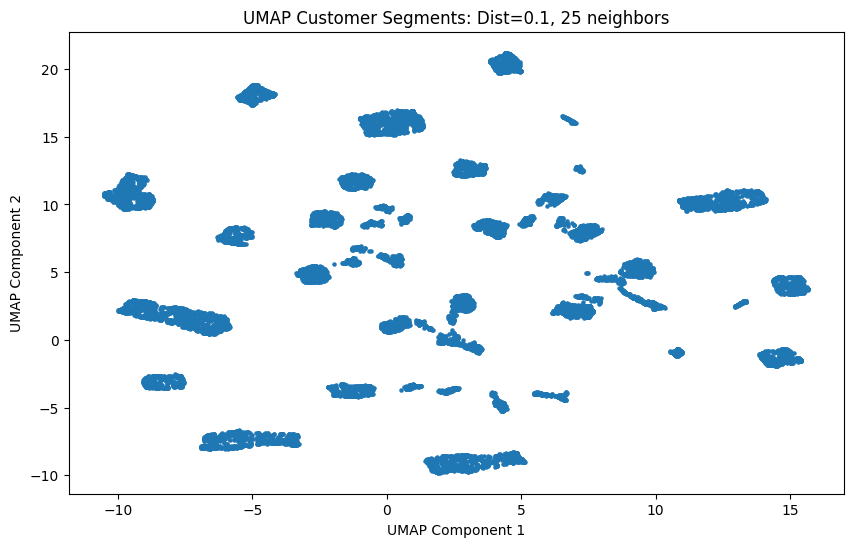

In [53]:
neighbors=25
dist=0.1

start_time = time.time()
umap_model = umap.UMAP(n_neighbors=neighbors, min_dist=dist)
umap_result = umap_model.fit_transform(X)
umap_runtime = time.time() - start_time
print(f"UMAP runtime: {umap_runtime:.2f} seconds")

plot_model(umap_result, f'UMAP Customer Segments: Dist={dist}, {neighbors} neighbors', 'UMAP Component 1', 'UMAP Component 2')


UMAP runtime: 14.45 seconds


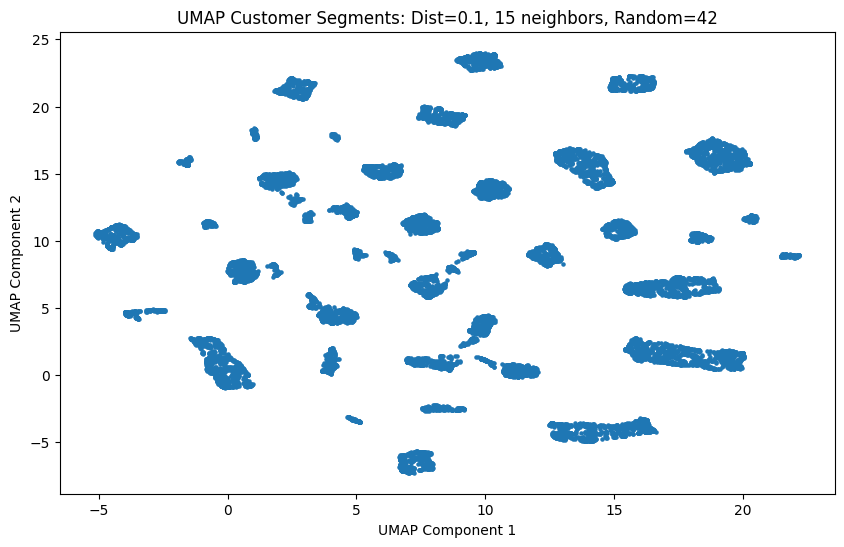

In [57]:
neighbors=15
dist=0.1

start_time = time.time()
umap_model_2 = umap.UMAP(n_neighbors=neighbors, min_dist=dist)
umap_result_2 = umap_model_2.fit_transform(X)
umap_runtime = time.time() - start_time
print(f"UMAP runtime: {umap_runtime:.2f} seconds")

plot_model(umap_result_2,  f'UMAP Customer Segments: Dist={dist}, {neighbors} neighbors, Random=42', 'UMAP Component 1', 'UMAP Component 2')

UMAP runtime: 15.70 seconds


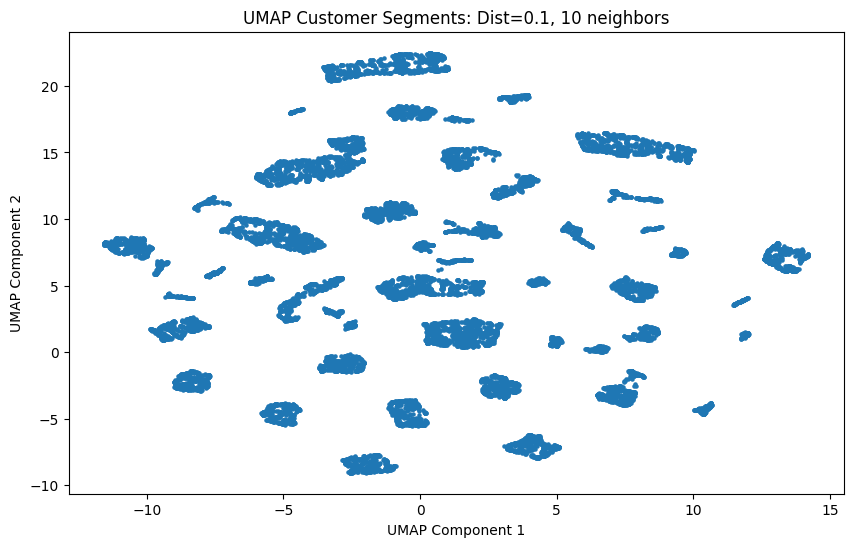

In [58]:
neighbors=10
dist=0.1

start_time = time.time()
umap_model_1 = umap.UMAP(n_neighbors=neighbors, min_dist=dist)
umap_result_1 = umap_model_1.fit_transform(X)
umap_runtime = time.time() - start_time
print(f"UMAP runtime: {umap_runtime:.2f} seconds")

plot_model(umap_result_1, f'UMAP Customer Segments: Dist={dist}, {neighbors} neighbors', 'UMAP Component 1', 'UMAP Component 2')

### KMeans & Silhouette Scoring

In [59]:
# Calculate silhouette scores for each UMAP model
kmeans = KMeans(n_clusters=35, random_state=42)

umap_cluster_labels = kmeans.fit_predict(umap_result)
umap_silhouette_score = silhouette_score(umap_result, umap_cluster_labels)
print(f"UMAP Silhouette Score: {umap_silhouette_score}")

UMAP Silhouette Score: 0.691498875617981


In [60]:
umap_1_cluster_labels = kmeans.fit_predict(umap_result_1)
umap_1_silhouette_score = silhouette_score(umap_result_1, umap_1_cluster_labels)
print(f"UMAP Silhouette Score: {umap_1_silhouette_score}")

UMAP Silhouette Score: 0.6318316459655762


In [61]:
umap_2_cluster_labels = kmeans.fit_predict(umap_result_2)
umap_2_silhouette_score = silhouette_score(umap_result_2, umap_2_cluster_labels)
print(f"UMAP Silhouette Score: {umap_2_silhouette_score}")

UMAP Silhouette Score: 0.6768709421157837


## t-SNE

t-SNE runtime: 159.29 seconds


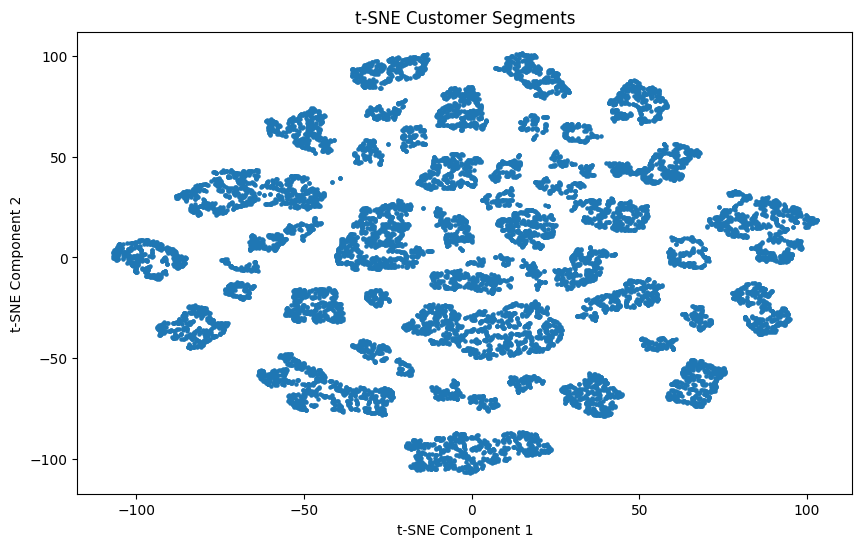

In [62]:
start_time = time.time()
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X)
tsne_runtime = time.time() - start_time
print(f"t-SNE runtime: {tsne_runtime:.2f} seconds")

plot_model(tsne_result, f't-SNE Customer Segments', 't-SNE Component 1', 't-SNE Component 2')

t-SNE runtime: 160.65 seconds


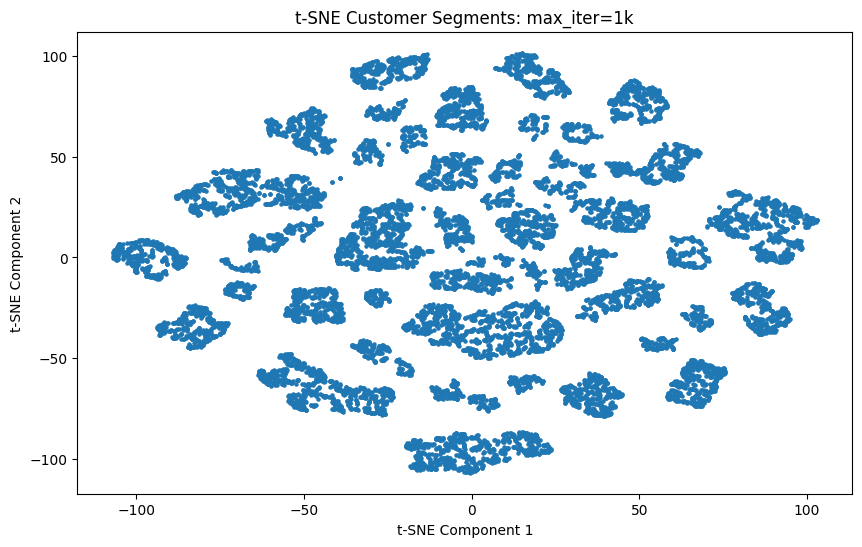

In [63]:
start_time = time.time()
tsne_1 = TSNE(n_components=2, max_iter=1000, random_state=42)
tsne_result_1 = tsne_1.fit_transform(X)
tsne_runtime = time.time() - start_time
print(f"t-SNE runtime: {tsne_runtime:.2f} seconds")

plot_model(tsne_result_1, f't-SNE Customer Segments: max_iter=1k', 't-SNE Component 1', 't-SNE Component 2')

### KMeans & Silhouette Scoring

In [71]:
# Calculate silhouette scores for each t-SNE model
kmeans_tsne = KMeans(n_clusters=42, random_state=42)

tsne_cluster_labels = kmeans_tsne.fit_predict(tsne_result)
tsne_silhouette_score = silhouette_score(tsne_result, tsne_cluster_labels)
print(f"t-SNE Silhouette Score: {tsne_silhouette_score}")

t-SNE Silhouette Score: 0.49990683794021606


In [72]:
tsne_1_cluster_labels = kmeans_tsne.fit_predict(tsne_result_1)
tsne_1_silhouette_score = silhouette_score(tsne_result_1, tsne_1_cluster_labels)
print(f"t-SNE Silhouette Score: {tsne_1_silhouette_score}")

t-SNE Silhouette Score: 0.49990683794021606


# Summary: Unsupervised Models

- Best Overall Model: `umap_model`
- `umap_result` silhouette score of `0.6915`

Runtime ranged from 18 - 40 seconds for UMAP, with most runtimes well under 30 seconds. As expected, this is significantly faster than t-SNE models, which never saw a completion faster than ~2.5 minutes.


All models posted a Silhouette Score ranging from `.35` when `KMeans` used less than 10 clusters, and `.6915` with `n_clusters=35`. UMAP again performed much better, posting scores over `.600` while t-SNE could not break the `0.500` mark. Visual inspection supports this, with UMAP models having much more defined boundaries and separation when compared to t-SNE.

---

# Applied Results
### With `umap_model`

We have our defined 'best' model, but still need to associate it with our data in a meaningful way. Since the data has been clustered, each record has been assigned a cluster value (as it belongs to). We can extend our DF with this, and subsequently group and query with the cluster value in mind.

In [73]:
# Assign cluster labels to our cleaned DF
df_cleaned = dfc.copy() # just to be safe :)
df_cleaned['Cluster'] = umap_cluster_labels

In [74]:
df_cleaned.head()

,Customer ID,Age,Gender,Loyalty Member,Product Type,SKU,Rating,Order Status,Payment Method,Total Price,Unit Price,Quantity,Purchase Date,Shipping Type,Add-ons Purchased,Add-on Total,Cluster
0,1000,53,Male,No,Smartphone,SKU1004,2,Cancelled,Credit Card,5538.33,791.19,7,3/20/2024,Standard,"Accessory,Accessory,Accessory",40.21,12
1,1000,53,Male,No,Tablet,SKU1002,3,Completed,Paypal,741.09,247.03,3,4/20/2024,Overnight,Impulse Item,26.09,29
3,1002,41,Male,Yes,Smartphone,SKU1004,2,Completed,Cash,3164.76,791.19,4,8/9/2024,Overnight,"Impulse Item,Impulse Item",60.16,18
4,1003,75,Male,Yes,Smartphone,SKU1001,5,Completed,Cash,41.50,20.75,2,5/21/2024,Express,Accessory,35.56,18
5,1004,41,Female,No,Smartphone,SKU1001,5,Completed,Credit Card,83.00,20.75,4,5/26/2024,Standard,"Impulse Item,Accessory",65.78,12


In [75]:
# Check out summary data for each identified cluster
df_cleaned.groupby('Cluster').describe()

Customer ID                                                         \
              count          mean          std      min       25%      50%   
Cluster                                                                      
0             325.0   8420.892308  5496.745936   1014.0   3806.00   7541.0   
1             395.0  15463.660759  2769.234480   3897.0  13142.00  15457.0   
2             382.0  15460.196335  2610.623509  11045.0  13216.75  15658.0   
3             407.0   5494.734644  2587.659863   1019.0   3490.00   5331.0   
4             408.0   5595.468137  2698.338480   1022.0   3100.50   5450.0   
5             474.0   5467.440928  2630.357589   1018.0   3284.00   5399.5   
6             468.0  15485.587607  2682.432100  11000.0  12966.50  15516.5   
7             480.0   7514.845833  4701.632527   1073.0   3835.25   6723.0   
8             401.0   5738.037406  2595.817892   1005.0   3696.00   5692.0   
9             318.0   5418.886792  2720.228281   1007.0   3033.00   5478.5   
10            395.0   5431.101266  2576.284599   1059.0   3130.00   5494.0   
11            410.0  13091.346341  5090.927500   1133.0  11033.75  14156.5   
12           1089.0   8370.087236  5034.109935   1000.0   4265.00   7605.0   
13            244.0  10432.036885  5511.872207   1061.0   5669.75   9862.5   
14            774.0  10761.850129  5730.675350   1014.0   5881.75  11471.5   
15            815.0  10664.244172  5496.857280   1053.0   5914.50  11232.0   
16             85.0   5231.788235  2614.530893   1006.0   3114.00   5026.0   
17            516.0   5481.335271  2585.190792   1008.0   3194.50   5444.0   
18            537.0   5334.020484  2518.849301   1002.0   3129.00   5480.0   
19            412.0  15482.169903  2636.426355  11083.0  12961.25  15577.5   
20            323.0   9165.362229  5382.500730   1060.0   4739.50   8253.0   
21            381.0  15517.808399  2542.418586  11077.0  13340.00  15478.0   
22            526.0  15331.741445  2675.077869  11029.0  13005.75  15255.0   
23            408.0  15398.580882  2664.445197  11022.0  12980.50  15462.0   
24            512.0  15311.527344  2558.167250  11009.0  13080.50  15248.0   
25            358.0  15581.586592  2538.548815  11043.0  13492.50  15794.5   
26            484.0  15450.733471  2659.776403  11005.0  13003.50  15471.5   
27            328.0  15680.673780  2436.423631  11012.0  13602.00  15832.5   
28            117.0   5499.888889  2519.163958   1184.0   3552.00   5349.0   
29            420.0   5362.783333  2682.764548   1000.0   2939.25   5178.5   
30            307.0   5637.527687  2589.227753   1063.0   3525.50   5707.0   
31            115.0   5208.521739  2578.990947   1073.0   2725.50   5360.0   
32            382.0  15434.808901  2733.593548  11012.0  12954.50  15650.0   
33            394.0  15620.979695  2589.757556  11046.0  13459.25  15684.0   
34            459.0   5731.331155  2605.261196   1024.0   3711.00   5874.0   

                               Age             ... Quantity        \
              75%      max   count       mean  ...      75%   max   
Cluster                                        ...                  
0        13049.00  19933.0   325.0  47.156923  ...      7.0  10.0   
1        17881.00  19996.0   395.0  47.108861  ...      8.0  10.0   
2        17686.50  19961.0   382.0  47.102094  ...      8.0  10.0   
3         7748.00   9969.0   407.0  49.297297  ...      8.0  10.0   
4         8172.25   9959.0   408.0  49.664216  ...      8.0  10.0   
5         7774.00   9994.0   474.0  48.989451  ...      8.0  10.0   
6        17864.25  19971.0   468.0  48.202991  ...      8.0  10.0   
7         9500.75  19888.0   480.0  50.116667  ...      7.0  10.0   
8         8088.00   9973.0   401.0  48.251870  ...      8.0  10.0   
9         7821.50   9984.0   318.0  49.537736  ...      9.0  10.0   
10        7511.50   9999.0   395.0  47.169620  ...      8.0  10.0   
11       17195.25  19958.0   410.0  50.795122  ...      8.0  10.0   
12      

In [76]:
# This satisfies our original business case, to identify customer segments!

# We can export this data into a CSV for external processing, or perform additional analysis...
# df_cleaned.to_csv('sales_with_customer_segments.csv', index=False)

In [77]:
# View some sample records when grouping by cluster
df_cleaned.groupby('Cluster').head()

,Customer ID,Age,Gender,Loyalty Member,Product Type,SKU,Rating,Order Status,Payment Method,Total Price,Unit Price,Quantity,Purchase Date,Shipping Type,Add-ons Purchased,Add-on Total,Cluster
0,1000,53,Male,No,Smartphone,SKU1004,2,Cancelled,Credit Card,5538.33,791.19,7,3/20/2024,Standard,"Accessory,Accessory,Accessory",40.21,12
1,1000,53,Male,No,Tablet,SKU1002,3,Completed,Paypal,741.09,247.03,3,4/20/2024,Overnight,Impulse Item,26.09,29
3,1002,41,Male,Yes,Smartphone,SKU1004,2,Completed,Cash,3164.76,791.19,4,8/9/2024,Overnight,"Impulse Item,Impulse Item",60.16,18
4,1003,75,Male,Yes,Smartphone,SKU1001,5,Completed,Cash,41.50,20.75,2,5/21/2024,Express,Accessory,35.56,18
5,1004,41,Female,No,Smartphone,SKU1001,5,Completed,Credit Card,83.00,20.75,4,5/26/2024,Standard,"Impulse Item,Accessory",65.78,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10203,11177,44,Male,No,Headphones,HDP456,4,Cancelled,Bank Transfer,2167.08,361.18,6,2/12/2024,Expedited,Accessory,13.65,21
10229,11196,68,Male,No,Headphones,HDP456,5,Completed,PayPal,1444.72,361.18,4,6/16/2024,Same Day,"Extended Warranty, Accessory, Accessory",205.64,33
10233,11198,32,Male,No,Tablet,TBL345,3,Completed,Credit Card,6291.28,786.41,8,8/20/2024,Standard,"Accessory, Impulse Item, Impulse Item",155.94,27
10258,11215,38,Male,No,Tablet,TBL345,2,Cancelled,Credit Card,5504.87,786.41,7,1/22/2024,Standard,"Extended Warranty, Accessory",133.17,27


In [78]:
# From here, we can perform any number of calculations to either build context, or understand trends...

# Calc the size of your given clusters; context for population density, total sales etc...
cluster_sizes = df_cleaned['Cluster'].value_counts()

# Calc distribution of top products per segment
cluster_product_distribution = df_cleaned.groupby('Cluster')['Product Type'].value_counts(normalize=True).reset_index(name='Proportion')
# Get the top product per segment
top_product_per_segment = cluster_product_distribution.loc[cluster_product_distribution.groupby('Cluster')['Proportion'].idxmax()]

# Calc the mean Total Price per segment
cluster_mean_total_price = df_cleaned.groupby('Cluster')['Total Price'].mean()

# Calc the rate of cancelled orders per segment
cluster_not_completed_orders = df_cleaned[df_cleaned['Order Status'] != 'Completed'].groupby('Cluster')['Order Status'].count() / df_cleaned.groupby('Cluster')['Order Status'].count()


print("Customer Segments, by size \n", cluster_sizes.sort_values(ascending=False))
print("")
print("Customer Segments, top product \n", top_product_per_segment)
print("")
print("Mean Total Price, per segment \n", cluster_mean_total_price.apply(lambda x: f"${x:,.2f}").sort_values(ascending=False))
print("")
print("Rate of Cancelled Orders, per segment \n", cluster_not_completed_orders.apply(lambda x: f"{x * 100:.2f}%").sort_values(ascending=False))


Customer Segments, by size 
 Cluster
12    1089
15     815
14     774
18     537
22     526
17     516
24     512
26     484
7      480
5      474
6      468
34     459
29     420
19     412
11     410
4      408
23     408
3      407
8      401
10     395
1      395
33     394
2      382
32     382
21     381
25     358
27     328
0      325
20     323
9      318
30     307
13     244
28     117
31     115
16      85
Name: count, dtype: int64

Customer Segments, top product 
     Cluster Product Type  Proportion
0         0   Smartphone    1.000000
1         1   Headphones    1.000000
2         2   Smartwatch    1.000000
3         3       Tablet    1.000000
4         4   Smartwatch    1.000000
5         5   Smartphone    1.000000
6         6       Laptop    1.000000
7         7       Tablet    1.000000
8         8       Laptop    1.000000
9         9   Smartphone    1.000000
10       10       Laptop    1.000000
11       11   Smartwatch    1.000000
12       12   Smartphone    1.000000


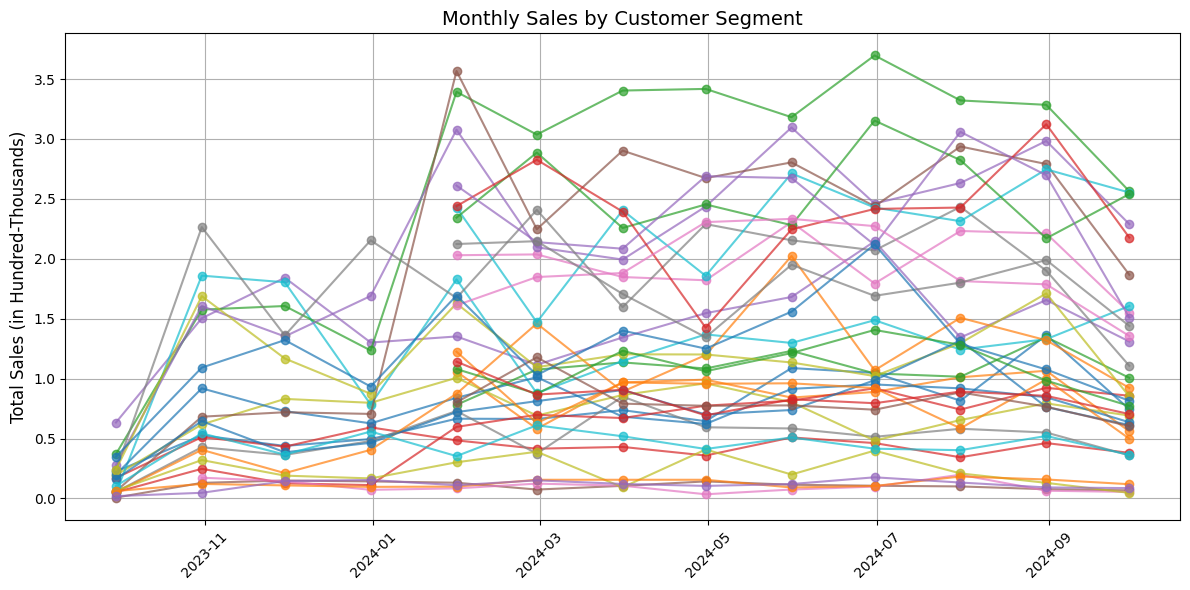

In [81]:
# Expanding on this, we can leverage customer segments to plot various aggregate values...

# Convert 'Purchase Date' to a datetime object (probably not required, but never hurts)
df_cleaned['Purchase Date'] = pd.to_datetime(df_cleaned['Purchase Date'])

# Group by Cluster, and also 'Purchase Date' + 'Total Price'
sales_by_cluster_date = df_cleaned.groupby(['Cluster', pd.Grouper(key='Purchase Date', freq='ME')])['Total Price'].sum().reset_index()

# Initialize the plot, and iterate over each unique cluster to plot sales count
plt.figure(figsize=(12, 6))

for cluster in sales_by_cluster_date['Cluster'].unique():
    cluster_data = sales_by_cluster_date[sales_by_cluster_date['Cluster'] == cluster]
    plt.plot(cluster_data['Purchase Date'], cluster_data['Total Price'] / 1e5,  # Divide by 100,000
             label=f'Cluster {cluster}', marker='o', alpha=0.7)


plt.ylabel('Total Sales (in Hundred-Thousands)', fontsize=12)
plt.title('Monthly Sales by Customer Segment', fontsize=14)
plt.xticks(rotation=45)

# Use ScalarFormatter to show numbers without scientific notation
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
plt.grid(True)
# plt.legend(title='Customer Segments', loc='lower center', fontsize=10)

plt.tight_layout()
plt.show()



---

# Summary

> Business Case: Marketing requests analysis on the previous year's sales data, to help discover customer segments for targeted advertising and promotional campaigns.

With `UMAP` and `KMeans` clustering, we analyzed relationships in sales data, and defined a range of criteria that resulted in a number of clusters being created, which reflect customer segments.

These segments were patched in to our existing sales data, at which point it can be readily exported or queried using other tools, in order to have a deeper understanding of one (or all) the segments. Provided to Marketing, they may have their own set of tools, processes or plans to further inspect and take action on that data.